In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import random
import os
from tqdm import tqdm 
import plotly.io as pio
pio.renderers.default = 'colab'

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

import gudhi as gd
import gudhi.representations

In [2]:
from architecture import Encoder, Decoder

# Import dataset

In [3]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)
# train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
# test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

/Users/michaelmontelli/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning:

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/torch/csrc/utils/tensor_numpy.cpp:180.)



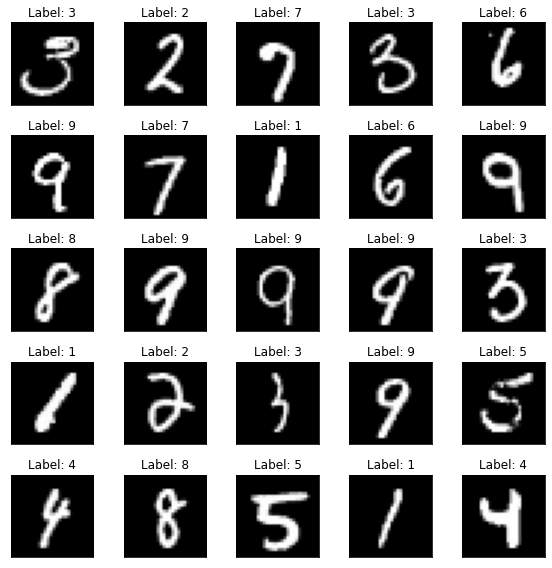

In [4]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [5]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

In [6]:
m = len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size = 256


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

# Loss

Dimension for encoded space?

In [7]:
torch.manual_seed(0)

encoded_space_dim = 3

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=encoded_space_dim, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=encoded_space_dim, fc2_input_dim=128)

In [8]:
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)


img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)


dec_img = decoder(img_enc)

print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 3])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [9]:
loss_fn = torch.nn.MSELoss()

lr = 0.001
#lr = 0.0008 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)
#optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=6e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
#model.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

# Train and test

In [10]:
# A dictionary with an int as key and the corresponding samples from the test data as value
numbers = {}
for number in range(10):
    numbers[number] = [sample for sample in test_dataset if sample[1] == number]
numbers[10] = test_dataset

In [11]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    
    for image_batch, _ in dataloader:  # ignore labels
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        
        encoded_data = encoder(image_batch)
        
        decoded_data = decoder(encoded_data)
        
        loss = loss_fn(decoded_data, image_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [12]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            
            encoded_data = encoder(image_batch)
            
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

### Visualization functions for training

In [13]:
def plot_ae_outputs(encoder, decoder, image_set=test_dataset, num_images=5):
    plt.figure(figsize=(10, 4.5))
    for i in range(num_images):
        ax = plt.subplot(2, num_images, i+1)
        img = image_set[i][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            encoded_img = encoder(img)
            rec_img = decoder(encoded_img)
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == num_images // 2:
            ax.set_title('Original images')
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == num_images // 2:
            ax.set_title('Reconstructed images')
    plt.show()   

**plot_persistence_landscapes**: How many landscapes, how many points for the simplcial complex? `num_landscapes`? `num_points`? Am I making the landscape correctly? Should I only be using 1-dimensional persistence data? Should `resolution` always be set to `num_points`?


**get_encoded_points_and_labels**: Currently using first `num_points` points from test data to make simplicial complex. How many should I use and how should I sample them? Should each visualization throughout training involve the same images?

**make_simplicial_complex**: How do I determine an appropriate `max_edge_length`? 

In [14]:
def plot_persistence_landscapes(encoder, decoder, image_set, num_landscapes=5, num_points=100):
    points = get_encoded_points_and_labels(encoder, decoder, image_set, num_points)[0]
    simplex_tree = make_simplicial_complex(points)
    features = get_persistence_features(simplex_tree)
    landscape_vectors = get_persistence_landscapes(features, num_landscapes, num_points)
    
    for i, landscape_vector in enumerate(landscape_vectors):
        plt.figure(figsize=(10, 4.5))
        if len(landscape_vector) > 0:
            plt.title(f'{i}-dim')
            for i in range(num_landscapes):
                plt.plot(landscape_vector[0][i * num_points:(i + 1) * num_points])
        plt.show()
    
    
# Helper methods
def get_encoded_points_and_labels(encoder, decoder, image_set, num_points=None):
    points = []
    labels = []
    if num_points is None:
        num_points = len(image_set)
    for i in range(num_points):
        img = image_set[i][0].unsqueeze(0).to(device)
        label = image_set[i][1]
        labels.append(label)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            encoded_img = encoder(img)
            rec_img = decoder(encoded_img)
        encoded_img = encoded_img.flatten().cpu().numpy()
        points.append(encoded_img)
    return points, labels


def make_simplicial_complex(points):
    skeleton = gd.RipsComplex(points=points, max_edge_length=2)
    simplex_tree = skeleton.create_simplex_tree(max_dimension=2)
    return simplex_tree


def get_persistence_features(simplex_tree):
    barcodes = simplex_tree.persistence()
    zero_dim_features = simplex_tree.persistence_intervals_in_dimension(0)
    one_dim_features = simplex_tree.persistence_intervals_in_dimension(1)
    two_dim_features = simplex_tree.persistence_intervals_in_dimension(2)

    features = [zero_dim_features, one_dim_features, two_dim_features]
    features = normalize_features(features, 1000)
    return features


def normalize_features(features, max_value):
    for k_dim_features in features:
        for feature in k_dim_features:
            if feature[1] == float('inf'):
                feature[1] = max_value
    return features


def get_persistence_landscapes(features, num_landscapes, num_points):
    landscape = gd.representations.Landscape(num_landscapes=num_landscapes, resolution=num_points)
    landscape_vectors = np.zeros((len(features), num_landscapes * num_points))
    for i, k_dim_features in enumerate(features):
        if len(k_dim_features) > 0:
            landscape_vector = landscape.fit_transform([k_dim_features])
            landscape_vectors[i] += landscape_vector.flatten()
    return np.array(landscape_vectors)


In [15]:
def plot_average_persistence_landscapes(encoder, decoder, image_set, num_landscapes=5, num_points=100):
    num_batches = len(image_set) // num_points
    landscape_vectors_sum = np.zeros((3, num_landscapes * num_points))
    for batch_num in range(num_batches):
        start_index = batch_num * num_points
        points = get_encoded_points_and_labels_by_index(encoder, decoder, image_set, num_points, start_index)[0]
        simplex_tree = make_simplicial_complex(points)
        features = get_persistence_features(simplex_tree)
        landscape_vectors = get_persistence_landscapes(features, num_landscapes, num_points)
        landscape_vectors_sum += landscape_vectors
    
    landscape_vectors_average = landscape_vectors_sum / num_points
    for i, landscape_vector in enumerate(landscape_vectors_average):
        plt.figure(figsize=(10, 4.5))
        if len(landscape_vector) > 0:
            plt.title(f'{i}-dim')
            for i in range(num_landscapes):
                plt.plot(landscape_vector[i * num_points:(i + 1) * num_points])
        plt.show()
        

def get_encoded_points_and_labels_by_index(encoder, decoder, image_set, num_points=None, start_index=0):
    points = []
    labels = []
    if num_points is None:
        num_points = len(image_set)
    for i in range(start_index, start_index + num_points):
        img = image_set[i][0].unsqueeze(0).to(device)
        label = image_set[i][1]
        labels.append(label)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            encoded_img = encoder(img)
            rec_img = decoder(encoded_img)
        encoded_img = encoded_img.flatten().cpu().numpy()
        points.append(encoded_img)
    return points, labels

In [17]:
def plot_encoded_points(encoded_samples, labels, image_set):
    encoded_samples_np = np.array(encoded_samples)
    fig = plt.figure(figsize=(24, 12))
    ax = fig.add_subplot(projection='3d')
    xs, ys, zs = encoded_samples_np[:, 0], encoded_samples_np[:, 1], encoded_samples_np[:, 2]
    sc = ax.scatter(xs, ys, zs, c=labels, cmap='tab10')
    if image_set == test_dataset:
        fig.colorbar(sc)
    plt.show()

In [18]:
def plot_all_encoded_points():
    encoded_samples, labels = get_all_encoded_points()
    
    fig = plt.figure(figsize=(24, 12))
    ax = fig.add_subplot(projection='3d')

    xs, ys, zs = encoded_samples[:, 0], encoded_samples[:, 1], encoded_samples[:, 2]
    labels = encoded_samples[:, 3]
    sc = ax.scatter(xs, ys, zs, c=labels, cmap='tab10')
    fig.colorbar(sc)
    plt.show()
    

def get_all_encoded_points():
    encoded_samples = []
    for sample in tqdm(test_dataset):
        img = sample[0].unsqueeze(0).to(device)
        label = sample[1]
        # Encode image
        encoder.eval()
        with torch.no_grad():
            encoded_img = encoder(img)
        # Append to list
        encoded_img = encoded_img.flatten().cpu().numpy()
        encoded_samples.append([*encoded_img, label])
    return np.array(encoded_samples), labels

### Training

Need to fix plots so axes are the same.


 EPOCH 1/20 	 train loss 0.133 	 val loss 0.082


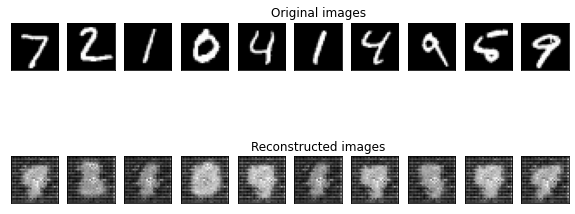

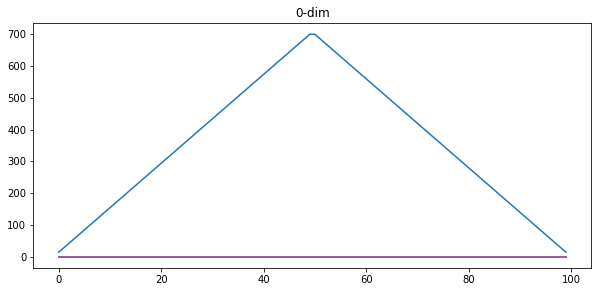

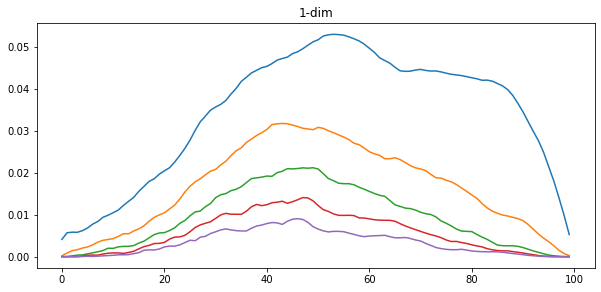

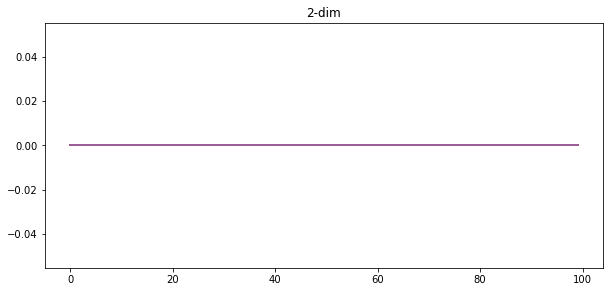

100%|██████████| 10000/10000 [00:02<00:00, 3539.14it/s]


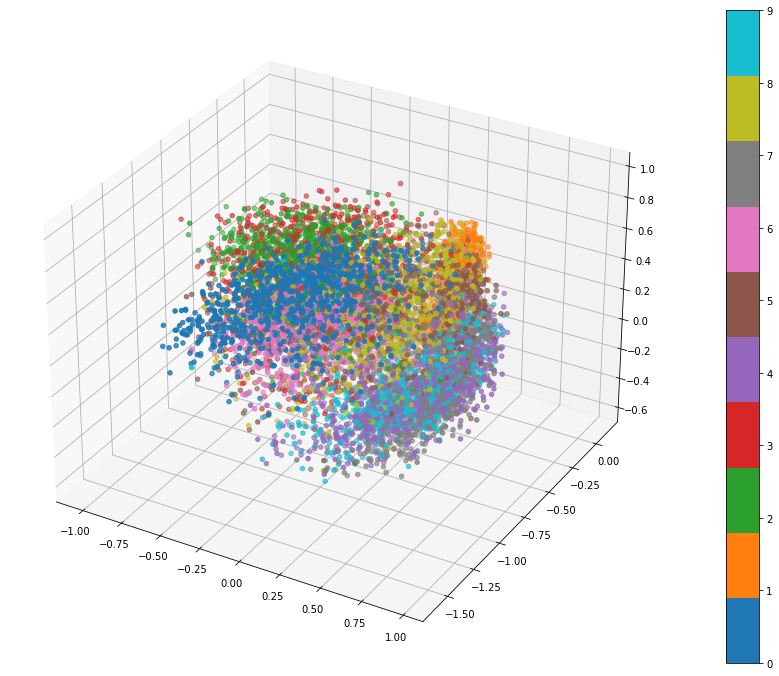


 EPOCH 2/20 	 train loss 0.060 	 val loss 0.046


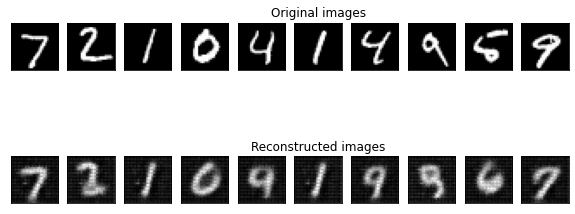


 EPOCH 3/20 	 train loss 0.042 	 val loss 0.039


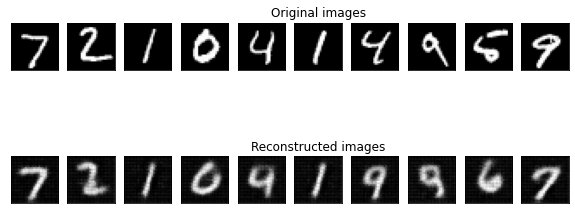


 EPOCH 4/20 	 train loss 0.038 	 val loss 0.037


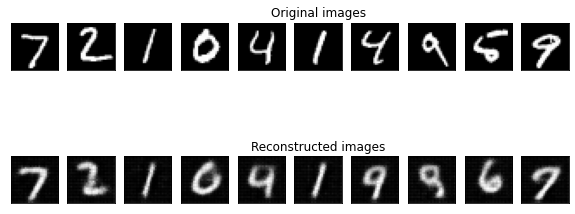


 EPOCH 5/20 	 train loss 0.036 	 val loss 0.035


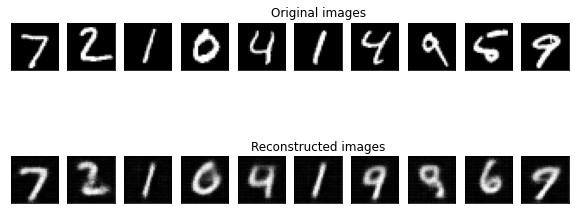

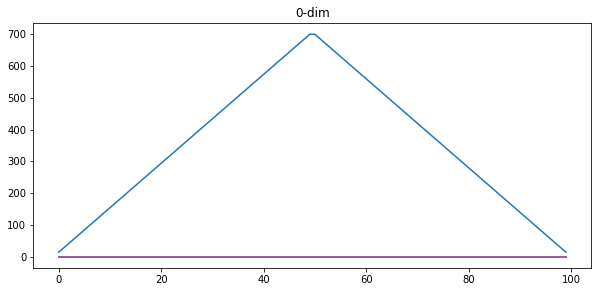

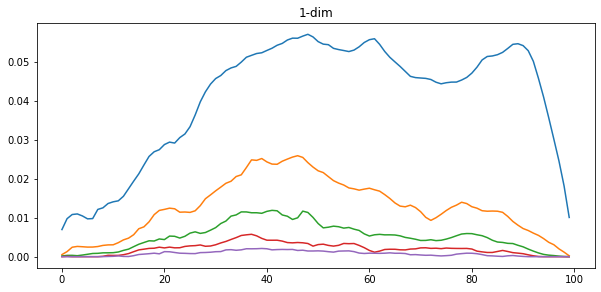

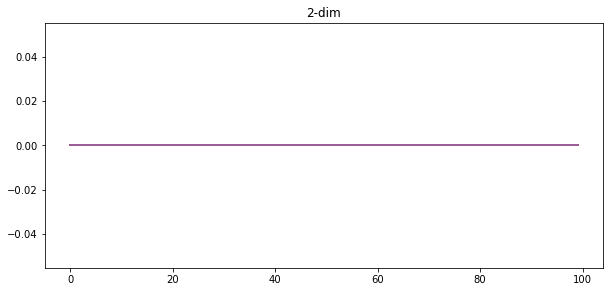

100%|██████████| 10000/10000 [00:02<00:00, 3723.19it/s]


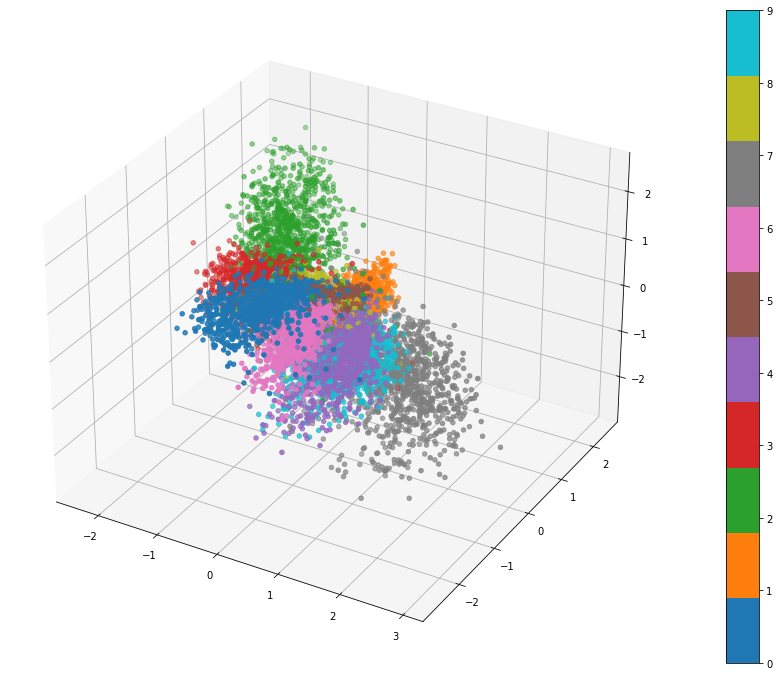


 EPOCH 6/20 	 train loss 0.035 	 val loss 0.035


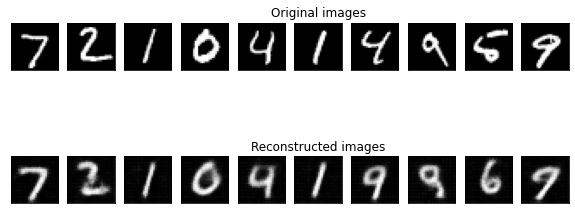


 EPOCH 7/20 	 train loss 0.034 	 val loss 0.034


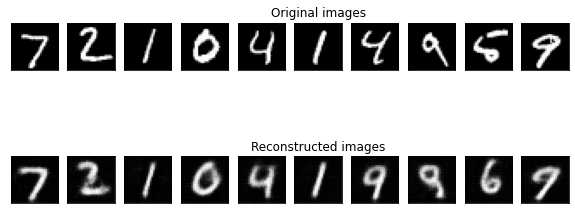


 EPOCH 8/20 	 train loss 0.034 	 val loss 0.034


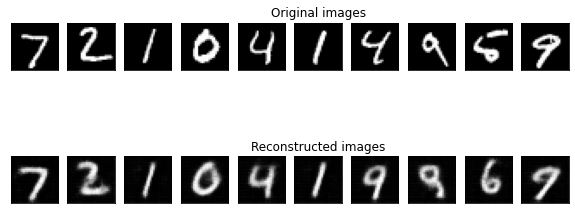


 EPOCH 9/20 	 train loss 0.033 	 val loss 0.033


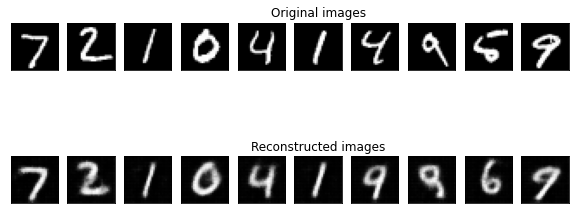


 EPOCH 10/20 	 train loss 0.033 	 val loss 0.033


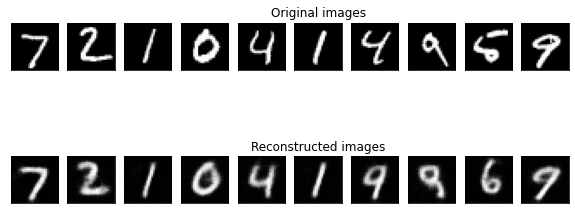

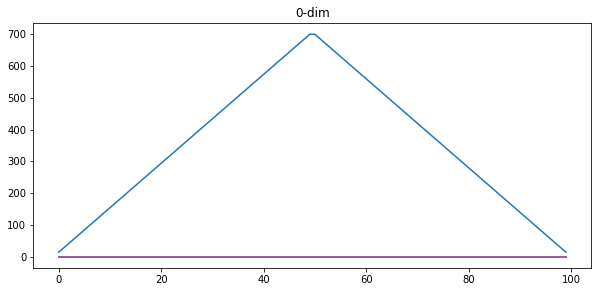

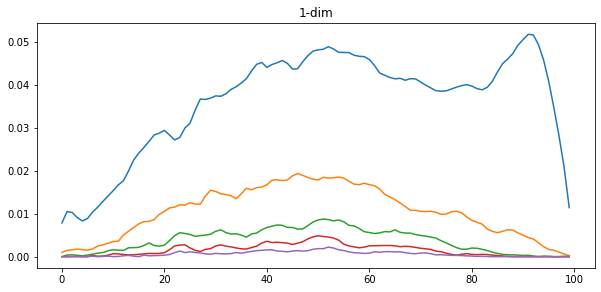

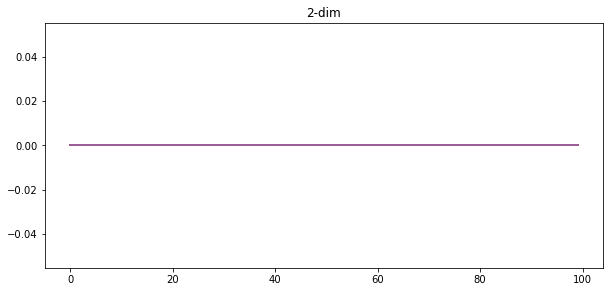

100%|██████████| 10000/10000 [00:02<00:00, 3620.74it/s]


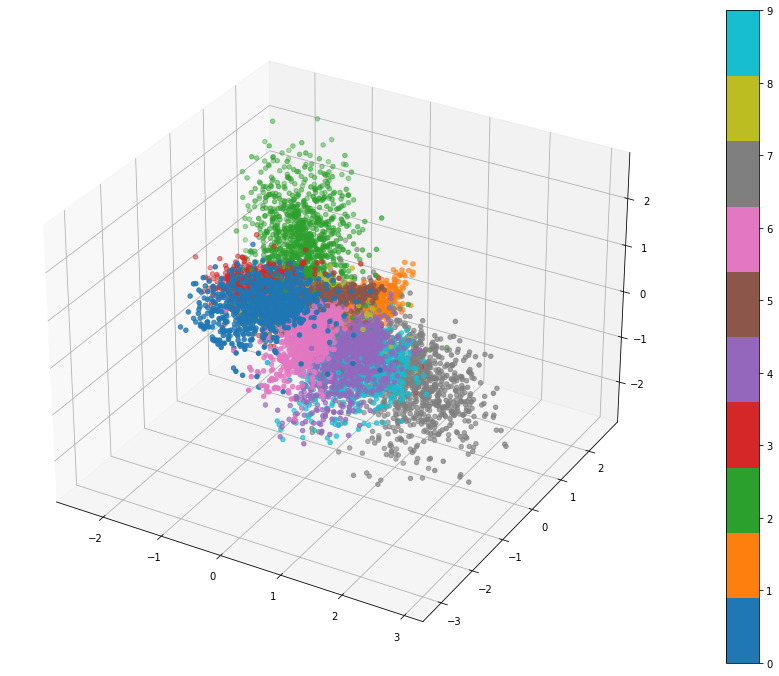


 EPOCH 11/20 	 train loss 0.032 	 val loss 0.033


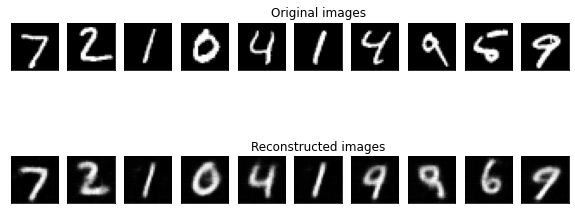


 EPOCH 12/20 	 train loss 0.032 	 val loss 0.032


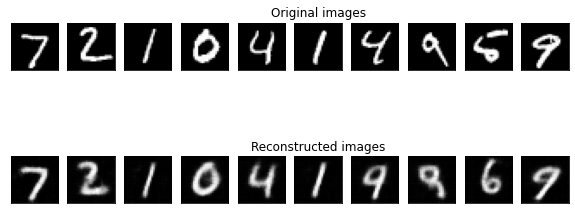


 EPOCH 13/20 	 train loss 0.032 	 val loss 0.032


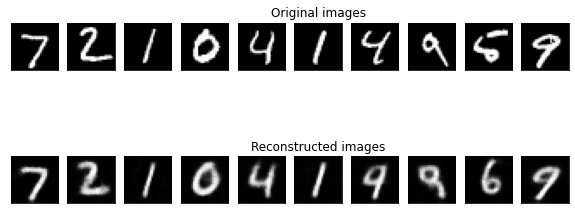


 EPOCH 14/20 	 train loss 0.032 	 val loss 0.032


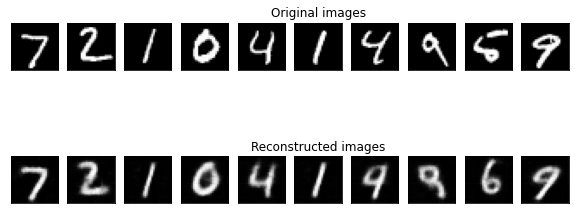


 EPOCH 15/20 	 train loss 0.032 	 val loss 0.032


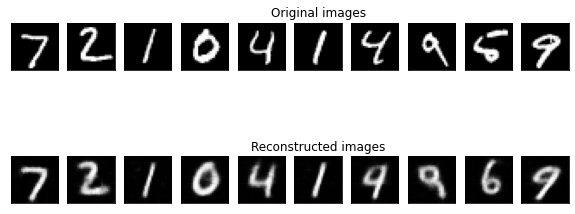

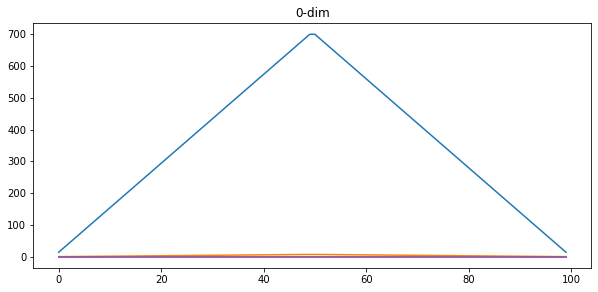

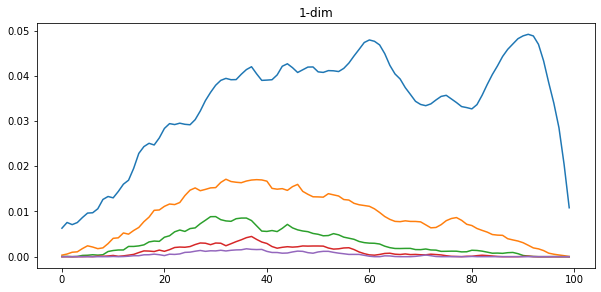

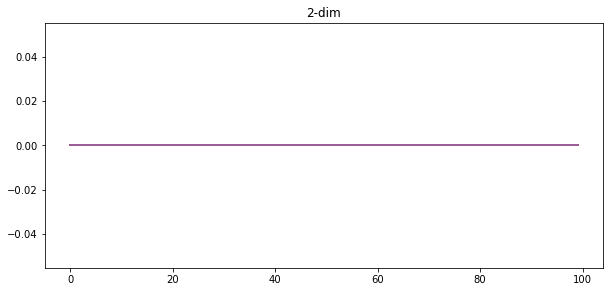

100%|██████████| 10000/10000 [00:02<00:00, 3522.48it/s]


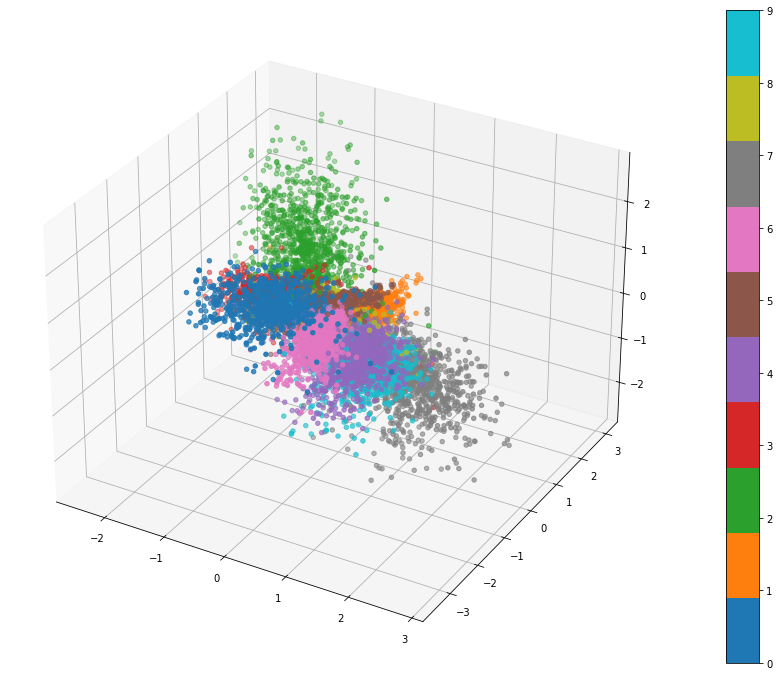


 EPOCH 16/20 	 train loss 0.031 	 val loss 0.032


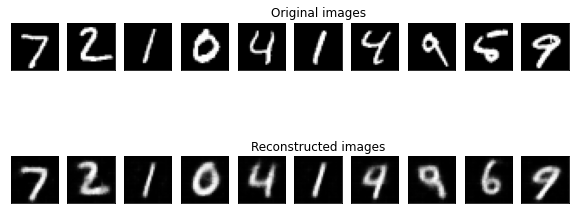


 EPOCH 17/20 	 train loss 0.031 	 val loss 0.032


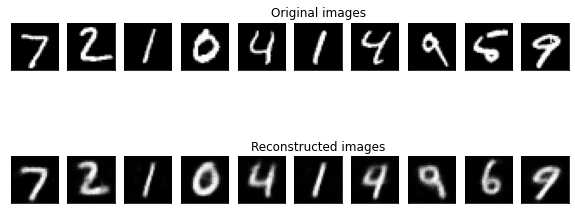


 EPOCH 18/20 	 train loss 0.031 	 val loss 0.032


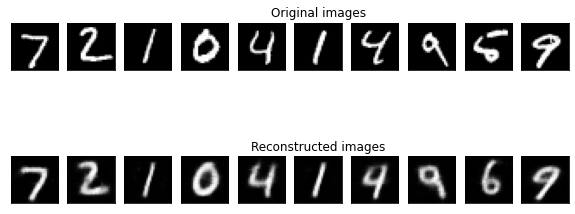


 EPOCH 19/20 	 train loss 0.031 	 val loss 0.031


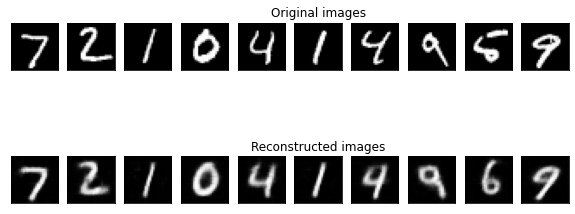


 EPOCH 20/20 	 train loss 0.031 	 val loss 0.031


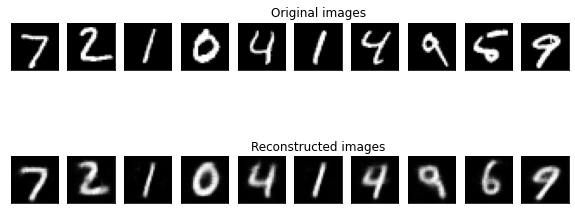

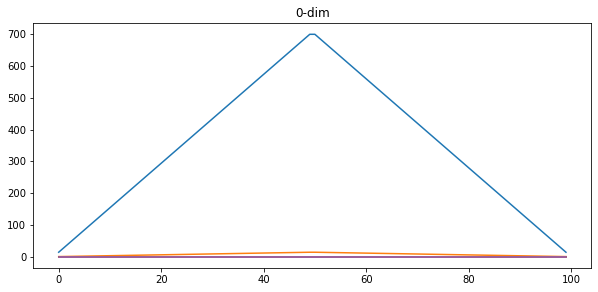

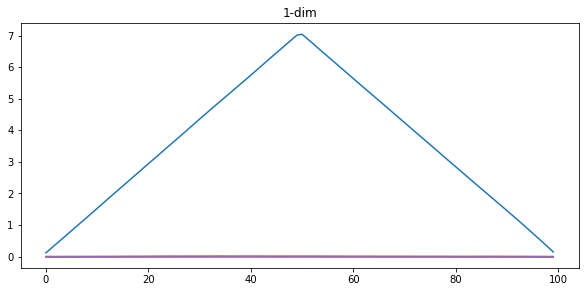

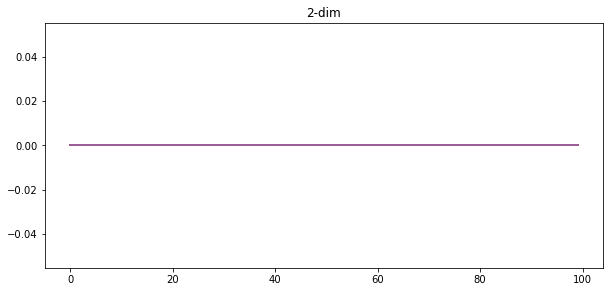

100%|██████████| 10000/10000 [00:02<00:00, 3435.34it/s]


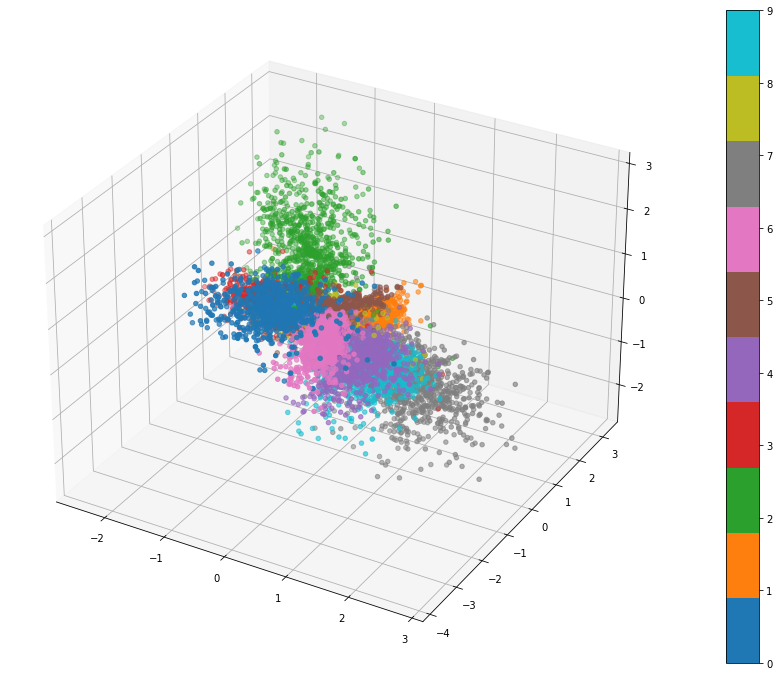

In [19]:
num_epochs = 20
num_images = 10
number_shown = 10    # if number_shown == 10, all numbers used
image_set = numbers[number_shown]
num_points = 100
history = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(encoder, decoder, device, train_loader, loss_fn,optim)
    val_loss = test_epoch(encoder, decoder, device, valid_loader, loss_fn)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs, train_loss, val_loss))
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    # plot
    plot_ae_outputs(encoder, decoder, image_set, num_images)
    if epoch == 0 or epoch % 5 == 4:  
        # plot_persistence_landscapes(encoder, decoder, image_set=image_set, num_points=num_points)
        plot_average_persistence_landscapes(encoder, decoder, image_set, num_points=num_points)
        points, labels = get_encoded_points_and_labels(encoder, decoder, image_set, num_points)
        plot_all_encoded_points()
    

In [20]:
test_epoch(encoder, decoder, device, test_loader, loss_fn).item()

0.03137669339776039

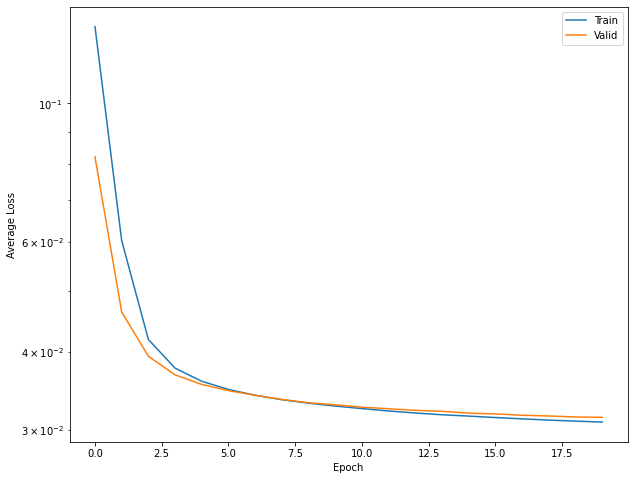

In [21]:
test_epoch(encoder, decoder, device, test_loader, loss_fn).item() # Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(history['train_loss'], label='Train')
plt.semilogy(history['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()